In [101]:
import pickle
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import random

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score


In [104]:
with open("data.pkl",'rb') as fp:
    data = pickle.load(fp)


# print(len(data))
# print(train_data[0][0])
# print(test_data[0][0])
# print(data[0][0])

    

[   0    1    3 ... 6524 6525 6527]


TypeError: only integer scalar arrays can be converted to a scalar index

In [115]:
def get_entries(data, index):
    new_data = []
    print(len(index))
#     print(index[500])
    for i in index:
        new_data.append(data[i])
    return new_data

labels = []
for entry in data:
    labels.append(entry[-1])

skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

for train_index, test_index in skf.split(data,labels):
    print(get_entries(data,[]))
    

1
[[array([33.        , 26.        ,  5.        ,  8.        , 11.        ,
       60.        , 22.        , 59.        ,  1.83187109,  7.66666667,
        1.3662601 , 10.        ,  0.06896552,  7.        ,  4.        ]), array([-5.27166016e-02,  1.95111129e-02, -1.13468714e-01, -6.54139593e-02,
        8.90918896e-02,  1.04720742e-02,  3.28070402e-01,  4.23632897e-02,
       -2.70392708e-02, -1.43078631e-02,  4.35752571e-02, -1.70819715e-01,
       -4.45311852e-02, -2.40526989e-01, -8.33250284e-02, -1.22428844e-02,
       -4.37446237e-02,  8.61228704e-02,  1.10468715e-01,  5.68504073e-02,
        3.67352031e-02,  2.27153990e-02,  6.76281080e-02,  3.96065563e-02,
       -9.72608849e-02,  1.01404086e-01,  1.02220647e-01,  1.51116950e-02,
        7.29609728e-02, -6.33764789e-02,  1.76194549e-01,  4.58289236e-02,
       -7.66886547e-02, -1.19962409e-01,  4.42762719e-03,  4.90530953e-02,
        2.58376282e-02,  3.54838260e-02, -1.52256995e-01, -1.26583219e-01,
       -1.91097334e-01,  6.7

In [4]:
def create_tensors(data_list):
    # create tensor that is compatible to load and train in the language model
    ds = {}
    keys = ['skills','subtests','questions','answers','y']
    for key in keys:
        ds[key] = []
    
    for entry in data_list:
        ds['skills'].append(entry[0])
        ds['subtests'].append(entry[1])
        ds['questions'].append(entry[2])
        ds['answers'].append(entry[3])
        ds['y'].append(entry[4])
    
    ds['skills'] = torch.tensor(ds['skills']).type(torch.float)
    ds['subtests'] = torch.tensor(ds['subtests'])
    ds['questions'] = torch.tensor(ds['questions'])
    ds['answers'] = torch.tensor(ds['answers'])
    ds['y'] = torch.tensor(ds['y']).type(torch.float)

    return ds

In [5]:
class BertModel(nn.Module):
    def __init__(self, sentence_dim, skill_dim, dropout):
        super().__init__()
        self.skill_dim = skill_dim
        self.fc_test = nn.Linear(768,sentence_dim)
        self.fc_question = nn.Linear(768,sentence_dim)
        self.fc_answer = nn.Linear(768,sentence_dim)
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(3*sentence_dim+skill_dim*2,128)
        self.out = nn.Linear(128,1)
    
    def forward(self, skills,test,question,answer):
        x1 = self.fc_skill(skills[:,:skill_dim])
        x2 = self.fc_test(test)
        x3 = self.fc_question(question)
        x4 = self.fc_answer(answer)
        x = torch.cat((x1,x2,x3,x4),dim=1)
        x = self.fc2(self.relu(x))
        pred = self.out(self.relu(x))
        
        return pred

In [6]:
class SimpleNet(nn.Module):
    def __init__(self, skill_dim):
        super().__init__()
        self.fc_skill = nn.Linear(skill_dim,skill_dim*2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(skill_dim*2,128)
        self.out = nn.Linear(128,1)
        
    def forward(self, skills):
        x1 = self.fc_skill(skills)
        x = self.fc2(self.relu(x1))
        pred = self.out(self.relu(x))
        return pred

In [7]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [8]:
def confusion_matrix(preds, Y):
    rounded_preds = torch.round(preds.sigmoid())
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i, value in enumerate(rounded_preds):
        if value == Y[i] and value == 1:
            TP += 1
        elif value == Y[i] and value == 0:
            TN += 1
        elif value != Y[i] and value == 0:
            FN += 1
        elif value != Y[i] and value == 1:
            FP += 1
        else:
            print(value,Y[i])
    print(f'TP: {TP}\tFN: {FN}')
    print(f'FP: {FP}\tTN: {TN}')

In [9]:

def precision(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
#     print((rounded_preds==1).sum())
#     print((y==1).sum())
    return precision_score(y,rounded_preds)

def recall(preds,y):
    rounded_preds = torch.round(preds.sigmoid())
    return recall_score(y,rounded_preds)
    

In [10]:
def train(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills'],data['subtests'],data['questions'],data['answers']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 


In [118]:
def evaluate(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():

        predictions = model(data['skills'],data['subtests'],data['questions'],data['answers']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        if matrix:
            confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [125]:
max_epochs = 300
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 64
skill_dim = 9
dropout = 0.1
verbose = False

model_results = []

for i in range(5):
    print(f"Run {i}")
    train_data, test_data = train_test_split(data, test_size=0.2, random_state = i)
    net = BertModel(sentence_dim, skill_dim, dropout)
    criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
    train_ds = create_tensors(train_data)
    test_ds = create_tensors(test_data)

    max_stats = [0,0,0,0,0] # each position represents acc, prec, recall, f1, epoch number respectively
    for epoch in range(max_epochs):
        train_loss, train_acc = train(net,train_ds,optimizer,criterion)

        if epoch % ep_log_interval == 0:
            
            valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=False)
            if verbose:
                print(f'Epoch: {epoch}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                print('precision: ', prec)
                print('recall: ', rec)
                try:
                    f1 = 2*(prec*rec)/(prec+rec)
                    print(f"f1 = {f1}")
                except:
                    continue
            if valid_acc > max_stats[0]:
                max_stats[0] = float(valid_acc)
                max_stats[1] = prec
                max_stats[2] = rec
                max_stats[3] = f1
                max_stats[4] = epoch
                
    print(max_stats)        
    model_results.append(max_stats)

print(model_results)

Run 0
[0.7067381143569946, 0.7151741293532339, 0.7887517146776406, 0.7206965840589418, 100]
Run 1
[0.6990811824798584, 0.695822454308094, 0.7691197691197691, 0.7206965840589418, 150]
Run 2
[0.7052067518234253, 0.7241847826086957, 0.7454545454545455, 0.7206965840589418, 50]
Run 3
[0.713629424571991, 0.7229080932784636, 0.753934191702432, 0.7206965840589418, 125]
Run 4


/Users/bnie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7143951058387756, 0.7370517928286853, 0.7602739726027398, 0.7206965840589418, 200]
[[0.7067381143569946, 0.7151741293532339, 0.7887517146776406, 0.7206965840589418, 100], [0.6990811824798584, 0.695822454308094, 0.7691197691197691, 0.7206965840589418, 150], [0.7052067518234253, 0.7241847826086957, 0.7454545454545455, 0.7206965840589418, 50], [0.713629424571991, 0.7229080932784636, 0.753934191702432, 0.7206965840589418, 125], [0.7143951058387756, 0.7370517928286853, 0.7602739726027398, 0.7206965840589418, 200]]


In [83]:
max_epochs = 300
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 64
skill_dim = 15
dropout = 0.1

net = BertModel(sentence_dim, skill_dim, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
train_ds = create_tensors(train_data)
test_ds = create_tensors(test_data)

f1_max = [0,0]
for epoch in range(max_epochs):
    train_loss, train_acc = train(net,train_ds,optimizer,criterion)

    if epoch % ep_log_interval == 0:
        print(f'Epoch: {epoch}')
        valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('precision: ', prec)
        print('recall: ', rec)
        try:
            f1 = 2*(prec*rec)/(prec+rec)
            print(f"f1 = {f1}")
            if f1 > f1_max[0]:
                f1_max[0] = f1
                f1_max[1] = epoch
        except:
            continue

Epoch: 0
TP: 690	FN: 3
FP: 608	TN: 5
	Train Loss: 0.832 | Train Acc: 55.02%
	 Val. Loss: 0.701 |  Val. Acc: 53.22%
precision:  0.5315870570107858
recall:  0.9956709956709957
f1 = 0.6931190356604722
Epoch: 25
TP: 484	FN: 209
FP: 233	TN: 380
	Train Loss: 0.591 | Train Acc: 69.34%
	 Val. Loss: 0.626 |  Val. Acc: 66.16%
precision:  0.6750348675034867
recall:  0.6984126984126984
f1 = 0.6865248226950355
Epoch: 50
TP: 513	FN: 180
FP: 250	TN: 363
	Train Loss: 0.573 | Train Acc: 70.38%
	 Val. Loss: 0.604 |  Val. Acc: 67.08%
precision:  0.672346002621232
recall:  0.7402597402597403
f1 = 0.7046703296703296
Epoch: 75
TP: 520	FN: 173
FP: 248	TN: 365
	Train Loss: 0.566 | Train Acc: 71.26%
	 Val. Loss: 0.598 |  Val. Acc: 67.76%
precision:  0.6770833333333334
recall:  0.7503607503607503
f1 = 0.7118412046543464
Epoch: 100
TP: 523	FN: 170
FP: 235	TN: 378
	Train Loss: 0.560 | Train Acc: 71.41%
	 Val. Loss: 0.594 |  Val. Acc: 68.99%
precision:  0.6899736147757256
recall:  0.7546897546897547
f1 = 0.7208821

In [126]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(net)
test_ds['skills'].requires_grad_()
test_ds['subtests'].requires_grad_()
test_ds['questions'].requires_grad_()
test_ds['answers'].requires_grad_()


attr,delta = ig.attribute((test_ds['skills'],test_ds['subtests'],test_ds['questions'],test_ds['answers'])\
                          ,return_convergence_delta=True)


In [127]:
attr = attr[0].detach().numpy()
print(attr)

[[-0.44060634 -0.92038455  0.52715431 ...  0.          0.
   0.        ]
 [-0.54037446 -0.45963935  1.0788842  ...  0.          0.
   0.        ]
 [-0.09156721 -1.12738492  1.73224811 ...  0.          0.
   0.        ]
 ...
 [-0.88243831 -2.38517526  0.98373157 ...  0.          0.
   0.        ]
 [-0.84256117 -0.98651497  1.32021532 ...  0.          0.
   0.        ]
 [ 0.46706789 -1.31097957  1.48237069 ...  0.          0.
   0.        ]]


Average Feature Importances
G3.PPVT.Vocab.raw :  -0.244
G3.Elision.PA.raw :  -1.305
G3.Syn.GramCorrect.raw :  1.382
G3.OL.Spell.Total :  -0.023
G3.DigitSpan.raw :  0.354
G3.WordRecog :  1.969
G3.TOWRE.SWE.raw :  0.909
G3.TOWRE.PDE.raw :  2.604
G3.WordID.raw :  -0.233
Subtest Depth mean :  0.000
Subtest Depth stdev :  0.000
Subtest Depth max :  0.000
Subtest Rare Word Rate :  0.000
Question Depth mean :  0.000
Answer Depth mean :  0.000


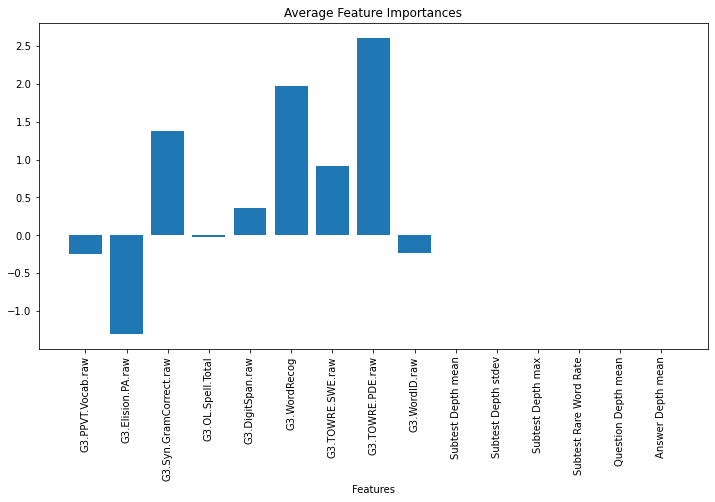

In [128]:

# attr = attr[0].detach().numpy()
from matplotlib import pyplot as plt

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, rotation='vertical')
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

In [22]:
print(f1_max)

[0.7234332425068118, 125]


In [23]:
max_epochs = 400
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 32
skill_dim = 9
dropout = 0.1

net = BertModel(sentence_dim, skill_dim, dropout)
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
train_ds = create_tensors(train_data)
test_ds = create_tensors(test_data)

f1_max = [0,0]
for epoch in range(max_epochs):
    train_loss, train_acc = train(net,train_ds,optimizer,criterion)

    if epoch % ep_log_interval == 0:
        print(f'Epoch: {epoch}')
        valid_loss, valid_acc, prec, rec = evaluate(net,test_ds,criterion,matrix=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('precision: ', prec)
        print('recall: ', rec)
        try:
            f1 = 2*(prec*rec)/(prec+rec)
            print(f"f1 = {f1}")
            if f1 > f1_max[0]:
                f1_max[0] = f1
                f1_max[1] = epoch
        except:
            continue

Epoch: 0
TP: 0	FN: 718
FP: 0	TN: 588
	Train Loss: 1.269 | Train Acc: 45.46%
	 Val. Loss: 1.026 |  Val. Acc: 45.02%
precision:  0.0
recall:  0.0
f1 = nan


/Users/bnie/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-23-3d7362532acf>:26: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*(prec*rec)/(prec+rec)


Epoch: 25
TP: 628	FN: 90
FP: 412	TN: 176
	Train Loss: 0.649 | Train Acc: 62.79%
	 Val. Loss: 0.655 |  Val. Acc: 61.56%
precision:  0.6038461538461538
recall:  0.8746518105849582
f1 = 0.714448236632537
Epoch: 50
TP: 525	FN: 193
FP: 274	TN: 314
	Train Loss: 0.615 | Train Acc: 66.47%
	 Val. Loss: 0.628 |  Val. Acc: 64.24%
precision:  0.6570713391739674
recall:  0.7311977715877437
f1 = 0.6921555702043507
Epoch: 75
TP: 542	FN: 176
FP: 262	TN: 326
	Train Loss: 0.592 | Train Acc: 68.67%
	 Val. Loss: 0.610 |  Val. Acc: 66.46%
precision:  0.6741293532338308
recall:  0.754874651810585
f1 = 0.7122207621550591
Epoch: 100
TP: 543	FN: 175
FP: 235	TN: 353
	Train Loss: 0.577 | Train Acc: 70.62%
	 Val. Loss: 0.598 |  Val. Acc: 68.61%
precision:  0.6979434447300771
recall:  0.7562674094707521
f1 = 0.7259358288770053
Epoch: 125
TP: 547	FN: 171
FP: 225	TN: 363
	Train Loss: 0.567 | Train Acc: 71.51%
	 Val. Loss: 0.588 |  Val. Acc: 69.68%
precision:  0.7085492227979274
recall:  0.7618384401114207
f1 = 0.734

In [55]:
print(f1_max)

[0.7427413909520595, 225]


In [86]:
feature_names = ['G3.PPVT.Vocab.raw',
                 'G3.Elision.PA.raw',
                 'G3.Syn.GramCorrect.raw',
                 'G3.OL.Spell.Total',
                 'G3.DigitSpan.raw',
                 'G3.WordRecog',
                 'G3.TOWRE.SWE.raw',
                 'G3.TOWRE.PDE.raw',
                 'G3.WordID.raw',
                 'Subtest Depth mean',
                 'Subtest Depth stdev',
                 'Subtest Depth max',
                 'Subtest Rare Word Rate',
                 'Question Depth mean',
                 'Answer Depth mean'
                 
                ]
print(len(feature_names))

15


### Simple NN model without text embeddings

In [24]:
def train_simple(model, data, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    optimizer.zero_grad()
    
    predictions = model(data['skills']).squeeze(1)

    loss = criterion(predictions, data['y'])
    

    acc = binary_accuracy(predictions, data['y'])
    

    loss.backward()

    optimizer.step()

#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#     print(loss)
#     print(acc)
    return loss,acc 

In [25]:
def evaluate_simple(model, data, criterion, matrix=False):
    
    model.eval()
    
    with torch.no_grad():

        predictions = model(data['skills']).squeeze(1)
        
#         print('eval pred',predictions)

        loss = criterion(predictions, data['y'])
#         print('eval1',data[4])
#         print('eval',(data[4]==0).sum())
        acc = binary_accuracy(predictions, data['y'])
        
        prec = precision(predictions, data['y'])
        
        rec = recall(predictions, data['y'])
        
        confusion_matrix(predictions, data['y'])
        
#         print(f"Number of positives: {(data[4]==1).sum()}")
#         print(f"Number of negatives: {(data[4]==0).sum()}")

        
    return loss, acc, prec, rec

In [94]:
max_epochs = 400
ep_log_interval = 25
lrn_rate = 0.001
sentence_dim = 128
skill_dim = 10
dropout = 0.1

net = SimpleNet(skill_dim)
criterion = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lrn_rate)
train_ds = create_tensors(train_data)
test_ds = create_tensors(test_data)

for epoch in range(max_epochs):
    train_loss, train_acc = train_simple(net,train_ds,optimizer,criterion)

    if epoch % ep_log_interval == 0:
        print(f'Epoch: {epoch}')
        valid_loss, valid_acc, prec, rec = evaluate_simple(net,test_ds,criterion,matrix=True)
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print('precision: ', prec)
        print('recall: ', rec)
        try:
            print(f"f1 = {2*(prec*rec)/(prec+rec)}")
        except:
            continue

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5222x15 and 10x20)